In [1]:
# Import necessary packages. 
import os
os.environ['PYSYN_CDBS'] = '/Users/alexgagliano/Documents/Research/2020oi/scripts/SPISEA/models/grp/hst/cdbs'

import numpy as np
import pylab as py
import os
import glob
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from specutils import Spectrum1D
import stsynphot as stsyn  
import astropy.units as u
import math
from synphot import Observation
import pysynphot as S
global sig_int
import pandas as pd
from scipy import interpolate
from extinction import ccm89, fitzpatrick99, apply
import matplotlib.image as mpimg
import george
from george.modeling import Model
from george.kernels import Matern32Kernel
from george.kernels import ExpSquaredKernel
from george.kernels import ExpSine2Kernel

os.chdir("/Users/alexgagliano/Documents/Research/2020oi/data/BPASS/BPASSv2.2.1_release-07-18-Tuatara/BPASSv2.2.1_sin-imf135_100")

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/alexgagliano/Documents/Research/2020oi/scripts/SPISEA/models/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
os.environ['PYSYN_CDBS']

'/Users/alexgagliano/Documents/Research/2020oi/scripts/SPISEA/models/grp/hst/cdbs'

In [48]:
Age_arr = []
newNames = {}
newNames[0] = "Angstrom"

for i in np.arange(52): 
    Age_arr.append(10**(6.+0.1*((i+2)-2.)))
    newNames[i+1] = int(Age_arr[i])
    
def gen_SED(theta):
    logAge = theta[0] 
    Z = theta[1]
    
    Age = 10**logAge

    metallicity = {0.001: '001', 0.002:'002', 0.003:'003', 0.004:'004', .006:'006', .008:'008', 
  0.010:'010', 0.014:'014', 0.020:'020', 0.030:'030',  0.040:'040', 1.e-4:'em4', 1.e-5:'em5'}
    metallicity_arr = [1.e-5, 1.e-4, 0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.014, 0.02, 0.03, 0.04]
    
    Z = find_nearest(metallicity_arr, Z)
    Age = find_nearest(Age_arr, Age)
    Zstr = metallicity[Z]
    fn = 'spectra-sin-imf135_100.z' + Zstr + '.dat'
    df = pd.read_csv(fn, delim_whitespace=True, header=None)
    df.rename(columns=newNames, inplace=True)
    wave = df['Angstrom'].values
    spec = df[int(Age)].values #Solar Luminosities per Angstrom, normalised for a cluster of 1e6
    # Msun formed in a single instantaneous burst.
    d = 5.277e25 #17.1 Mpc in cm 
    spec *=  3.848e26*1.e7/(4*np.pi*d**2)  #Lsun/A to erg/s/AA to erg/s/AA/cm^2
    R_V = 3.1
    #EBV_20oi = 0.173 
    EBV_20oi = 0.15
    AV_20oi = R_V*EBV_20oi
    spec = apply(ccm89(wave, AV_20oi, R_V, unit='aa'), spec) #redden spectrum given the extinction of 0.173 at 2020oi
    spec = S.ArraySpectrum(wave, spec, fluxunits='flam')
    return spec

def gen_synHST(spec):
    obs814_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f814w')).effstim('abmag')
    obs555_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f555w')).effstim('abmag')
    #obs330_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f330w'),  force='extrap').effstim('abmag')    
    obs160_ir = S.Observation(spec,S.ObsBandpass('wfc3,ir,f160w')).effstim('abmag')
    obs555_wfc3 = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f555w')).effstim('abmag')
    obs775_wfc3 = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f775w')).effstim('abmag')
    obs475_wfc3 = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f475w')).effstim('abmag')
    obs814_wfc3 = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f814w')).effstim('abmag')

    return np.array([obs555_hrc, obs814_hrc,obs160_ir, obs475_wfc3, obs555_wfc3, obs814_wfc3])     
    
def gen_phot(spec):
    obs814_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f814w')).effstim('abmag')
    obs555_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f555w')).effstim('abmag')
    obs330_hrc =S.Observation(spec,S.ObsBandpass('acs,hrc,f330w'),  force='extrap').effstim('abmag')    
    obs160_ir = S.Observation(spec,S.ObsBandpass('wfc3,ir,f160w')).effstim('abmag')
    obs555_wfc3 = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f555w')).effstim('abmag')
    obs775_wfc3 = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f775w')).effstim('abmag')
    obs475_wfc3 = S.Observation(spec,S.ObsBandpass('wfc3,uvis1,f475w')).effstim('abmag')
    
    c1 = obs814_hrc - obs555_hrc
    c2 = obs555_hrc - obs330_hrc
    c3 = obs330_hrc - obs160_ir
    c4 = obs160_ir - obs555_wfc3
    c5 = obs555_wfc3 - obs775_wfc3
    c6 = obs775_wfc3 - obs475_wfc3
    c7 = obs775_wfc3 - obs330_hrc
    c8 = obs814_hrc - obs160_ir
    
    return np.array([c1, c2, c3, c4, c5, c6, c7, c8])   

def fit(theta):
    spec = gen_SED(theta)
    phot = gen_phot(spec)
    return phot

In [49]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

In [14]:
# Step 1 - open the actual HST data for comparison 
#the actual observations
#note - need to convert to Vega AND absolute mag given distance and extinction!! 
HST_20oi = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/HST_preExplosionPhotometry_dataOnly.csv", delim_whitespace=True)
HST_20oi = HST_20oi.drop_duplicates(subset=['Instrument', 'Filter'])

f814_hrc = HST_20oi.loc[HST_20oi['Instrument'].isin(['ACS/HRC']) & HST_20oi['Filter'].isin(['F814W']), 'Magnitude'].values[0]
f555_hrc = HST_20oi.loc[HST_20oi['Instrument'].isin(['ACS/HRC']) & HST_20oi['Filter'].isin(['F555W']), 'Magnitude'].values[0]
f330_hrc = HST_20oi.loc[HST_20oi['Instrument'].isin(['ACS/HRC']) & HST_20oi['Filter'].isin(['F330W']), 'Magnitude'].values[0]
f160_ir = HST_20oi.loc[HST_20oi['Instrument'].isin(['WFC3/IR']) & HST_20oi['Filter'].isin(['F160W']), 'Magnitude'].values[0]
f555_wfc3 = HST_20oi.loc[HST_20oi['Instrument'].isin(['WFC3/UVIS']) & HST_20oi['Filter'].isin(['F555W']), 'Magnitude'].values[0]
f775_wfc3 = HST_20oi.loc[HST_20oi['Instrument'].isin(['WFC3/UVIS']) & HST_20oi['Filter'].isin(['F775W']), 'Magnitude'].values[0]
f475_wfc3 = HST_20oi.loc[HST_20oi['Instrument'].isin(['WFC3/UVIS']) & HST_20oi['Filter'].isin(['F475W']), 'Magnitude'].values[0]

f814_hrc_err = HST_20oi.loc[HST_20oi['Instrument'].isin(['ACS/HRC']) & HST_20oi['Filter'].isin(['F814W']), 'Uncertainty'].values[0]
f555_hrc_err = HST_20oi.loc[HST_20oi['Instrument'].isin(['ACS/HRC']) & HST_20oi['Filter'].isin(['F555W']), 'Uncertainty'].values[0]
f330_hrc_err = HST_20oi.loc[HST_20oi['Instrument'].isin(['ACS/HRC']) & HST_20oi['Filter'].isin(['F330W']), 'Uncertainty'].values[0]
f160_ir_err = HST_20oi.loc[HST_20oi['Instrument'].isin(['WFC3/IR']) & HST_20oi['Filter'].isin(['F160W']), 'Uncertainty'].values[0]
f555_wfc3_err = HST_20oi.loc[HST_20oi['Instrument'].isin(['WFC3/UVIS']) & HST_20oi['Filter'].isin(['F555W']), 'Uncertainty'].values[0]
f775_wfc3_err = HST_20oi.loc[HST_20oi['Instrument'].isin(['WFC3/UVIS']) & HST_20oi['Filter'].isin(['F775W']), 'Uncertainty'].values[0]
f475_wfc3_err = HST_20oi.loc[HST_20oi['Instrument'].isin(['WFC3/UVIS']) & HST_20oi['Filter'].isin(['F475W']), 'Uncertainty'].values[0]

#convert to absolute magnitude 
M_f814_hrc = f814_hrc
M_f555_hrc = f555_hrc
M_f330_hrc = f330_hrc
M_f160_ir = f160_ir
M_f555_wfc3 = f555_wfc3
M_f775_wfc3 = f775_wfc3
M_f475_wfc3 = f475_wfc3

obs_c1 = M_f814_hrc - M_f555_hrc
obs_c2 = M_f555_hrc - M_f330_hrc
obs_c3 = M_f330_hrc - M_f160_ir
obs_c4 = M_f160_ir - M_f555_wfc3
obs_c5 = M_f555_wfc3 - M_f775_wfc3
obs_c6 = M_f775_wfc3 - M_f475_wfc3
obs_c7 = M_f775_wfc3 - M_f330_hrc
obs_c8 = M_f814_hrc - M_f160_ir

obs = np.array([obs_c1, obs_c2, obs_c3, obs_c4, obs_c5, obs_c6, obs_c7, obs_c8])

obs_c1_err = np.sqrt(f814_hrc_err**2 + f475_wfc3_err**2)
obs_c2_err = np.sqrt(f555_hrc_err**2 + f330_hrc_err**2)
obs_c3_err = np.sqrt(f330_hrc_err**2 + f160_ir_err**2)
obs_c4_err = np.sqrt(f160_ir_err**2 + f555_wfc3_err**2)
obs_c5_err = np.sqrt(f555_wfc3_err**2 + f775_wfc3_err**2)
obs_c6_err = np.sqrt(f775_wfc3_err**2 + f475_wfc3_err**2)
obs_c7_err = np.sqrt(f775_wfc3_err**2 + f330_hrc_err**2)
obs_c8_err = np.sqrt(f814_hrc_err**2 + f160_ir_err**2)

obs_sig = np.array([obs_c1_err, obs_c2_err, obs_c3_err, obs_c4_err, obs_c5_err, obs_c6_err, obs_c7_err, obs_c8_err])

In [15]:
# Step 1 - import the best fit results for both the single and binary SEDs
resultDF_sin = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/bestFit_singleBPASS_HSTphot.csv")
resultDF_bin = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/bestFit_binaryBPASS_HSTphot.csv")

In [16]:
# Step 2.1 - find the best age and metallicity results for the single star SEDs
logAge_sin = resultDF_sin.loc[resultDF_sin['chi_sq'] == np.nanmin(resultDF_sin['chi_sq']), 'logAge'].values[0]
Z_sin = resultDF_sin.loc[resultDF_sin['chi_sq'] == np.nanmin(resultDF_sin['chi_sq']), 'Z'].values[0]

In [17]:
# Step 2.2 - find the best age and metallicity results for the binary star SEDs
logAge_bin = resultDF_bin.loc[resultDF_bin['chi_sq'] == np.nanmin(resultDF_bin['chi_sq']), 'logAge'].values[0]
Z_bin = resultDF_bin.loc[resultDF_bin['chi_sq'] == np.nanmin(resultDF_bin['chi_sq']), 'Z'].values[0]

In [50]:
# Step 3 - Generate the SEDs associated with the best-fit single and binary models
theta_sin = np.array([logAge_sin, Z_sin])
spec_sin = gen_SED(theta_sin)

theta_bin = np.array([logAge_bin, Z_bin])
spec_bin = gen_SED(theta_bin)

wave_sin = spec_sin.wave[::40]
flux_sin = spec_sin.flux[::40]

wave_bin = spec_bin.wave[::40]
flux_bin = spec_bin.flux[::40]

waves = {'sin': wave_sin, 'bin': wave_bin}
fluxes = {'sin': flux_sin, 'bin': flux_bin}

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [43]:
#the reddened SED
gen_synHST(spec_sin)
#[17.02850598, 17.28802432, 17.53583799, 16.96224597, 17.01708746,  17.28653493]
#[obs555_hrc, obs814_hrc,obs160_ir, obs475_wfc3, obs555_wfc3, obs814_wfc3]

array([17.02850598, 17.28802432, 17.53583799, 16.96224597, 17.01708746,
       17.28653493])

In [51]:
#the reddened SED, low extinction
gen_synHST(spec_sin)
#[16.95396184, 17.24517822, 17.52128862, 16.87546646, 16.94040818,17.24331566]
#[obs555_hrc, obs814_hrc,obs160_ir, obs475_wfc3, obs555_wfc3, obs814_wfc3]

array([16.95396184, 17.24517822, 17.52128862, 16.87546646, 16.94040818,
       17.24331566])

In [39]:
#the non-reddened SED
gen_synHST(spec_sin)
#[16.46698714, 16.96476778, 17.42636434, 16.30742548, 16.43852621, 16.96054044]
#[obs555_hrc, obs814_hrc,obs160_ir, obs475_wfc3, obs555_wfc3, obs814_wfc3]

array([16.46698714, 16.96476778, 17.42636434, 16.30742548, 16.43852621,
       16.96054044])

In [56]:
ext_corr = np.array([16.46698714, 16.96476778, 17.42636434, 16.30742548, 16.43852621, 16.96054044])-\
    np.array([17.02850598, 17.28802432, 17.53583799, 16.96224597, 17.01708746,  17.28653493])

In [57]:
ext_corr2 = np.array([16.46698714, 16.96476778, 17.42636434, 16.30742548, 16.43852621, 16.96054044])-\
             np.array([16.95396184, 17.24517822, 17.52128862, 16.87546646, 16.94040818,17.24331566])

In [59]:
ext_corr-ext_corr2

array([-0.07454414, -0.0428461 , -0.01454937, -0.08677951, -0.07667928,
       -0.04321927])

In [47]:
ext_corr
#[-0.56151884, -0.32325654, -0.10947365, -0.65482049, -0.57856125, -0.32599449]
#[obs555_hrc, obs814_hrc,obs160_ir, obs475_wfc3, obs555_wfc3, obs814_wfc3]

array([-0.56151884, -0.32325654, -0.10947365, -0.65482049, -0.57856125,
       -0.32599449])

In [ ]:
#Step 4 - Calculate 20 unique gp warps of the single star cluster SED

phot = {}
for model in ["sin", "bin"]:
    tempPhot = []
    wave_orig = waves[model]
    flux_orig = fluxes[model]
    for i in np.arange(20):
        kernel = 0.001*ExpSquaredKernel(1.e7, bounds=[0.9, 1.1])
        matern_gp = george.GP(kernel)
        pred = matern_gp.sample(wave_orig)
        pred+= 1 #shift upward to 1

        #make sure the realization deviates by the right amount
        fig = plt.figure(figsize=(10,7))
        plt.plot(wave_orig, pred)
        plt.title("GP realization")
        plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/img/BPASS_modelUncertainty/GP_deviation_%i_%s.png"% (i, model),dpi=300, bbox_inches='tight')
        plt.close(fig)
        
        #warp the spectrum
        flux_mod = flux_orig*pred
        DF = pd.DataFrame({'Wave(A)':wave_orig, 'Flux_Orig(Flam)':flux_orig, 'Flux_Warp(Flam)':flux_mod})
        DF.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/BPASS/BPASS_modelUncertainty/WarpedSED%i_%s.csv"%(i, model), index=False)

        #calculate the photometry of the spectrum
        spec = S.ArraySpectrum(wave_orig, flux_mod, fluxunits='flam')
        sim_phot = gen_phot(spec)
        np.savez("/Users/alexgagliano/Documents/Research/2020oi/data/BPASS/BPASS_modelUncertainty/WarpedSED%i_%s_HSTphot.npz"%(i, model), sim_phot)
        
        #save photometry
        tempPhot.append(sim_phot)
    #write to array of photometric observations
    phot[model] = tempPhot

In [321]:
#calculate the standard deviation between observations for the single model
tot_sig_sin = np.std(phot['sin'], axis=0)
#calculate the standard deviation between observations for the binary model
tot_sig_bin = np.std(phot['sin'], axis=0)

#subtract off the observational uncertainty
model_sig_sin = np.sqrt(tot_sig_sin**2 - obs_sig**2)
model_sig_bin = np.sqrt(tot_sig_bin**2 - obs_sig**2)

In [329]:
#print the result
print(model_sig_sin)
#print()
print(obs_sig)

[0.02060751 0.02036466 0.03641581 0.03167551 0.0175658  0.02306005
 0.03590246 0.03181545]
[0.00785493 0.00758222 0.00958019 0.008228   0.01118258 0.01118258
 0.01221188 0.01061037]


In [293]:
################### SANDBOX DIAGNOSTIC CODE ############################

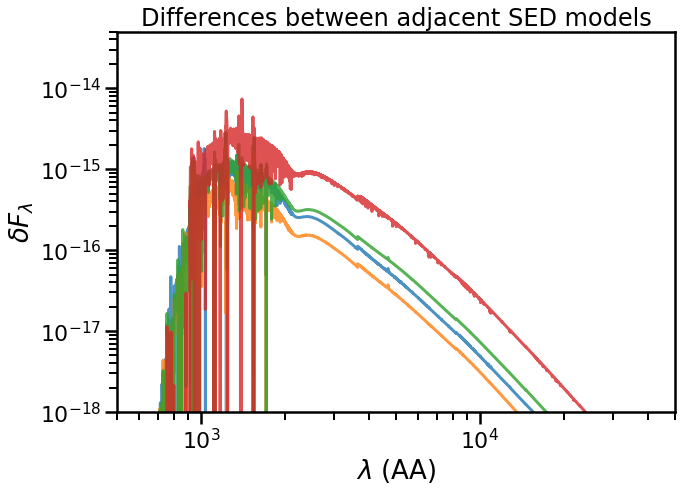

In [251]:
sns.set_context("poster")
plt.figure(figsize=(10,7))
plt.plot(spec.wave, flux_diffs[0], alpha=0.8)
plt.plot(spec.wave, flux_diffs[1], alpha=0.8)
plt.plot(spec.wave, flux_diffs[2], alpha=0.8)
plt.plot(spec.wave, flux_diffs[3], alpha=0.8)
plt.xscale("log")
plt.yscale("log")
plt.ylim((1.e-18, 5.e-14))
plt.xlim((5.e2, 5.e4))
plt.xlabel("$\lambda$ (AA)",fontsize=26)
plt.ylabel(r"$\delta F_{\lambda}$",fontsize=26)
plt.title("Differences between adjacent SED models");

Text(0, 0.5, '$F_{\\lambda}$')

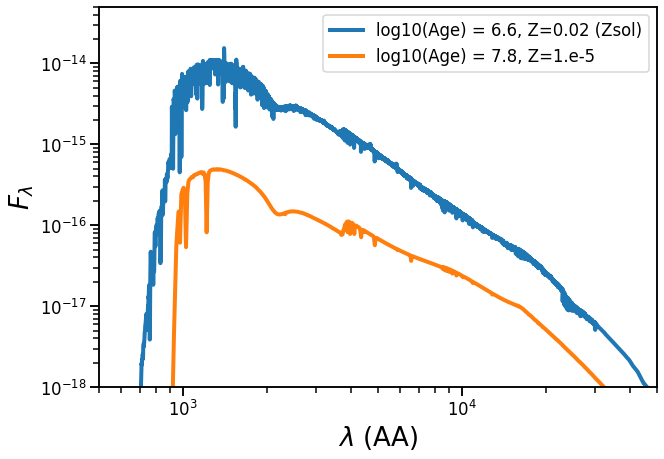

In [187]:
blended_flux = 0.2*spec.flux+ 0.8*spec2.flux

sns.set_context("talk")
plt.figure(figsize=(10,7))
plt.plot(spec.wave, spec.flux, lw=4,label='log10(Age) = 6.6, Z=0.02 (Zsol)')
plt.plot(spec2.wave, spec2.flux, lw=4, label='log10(Age) = 7.8, Z=1.e-5')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylim((1.e-18, 5.e-14))
plt.xlim((5.e2, 5.e4))
plt.xlabel("$\lambda$ (AA)",fontsize=26)
plt.ylabel(r"$F_{\lambda}$",fontsize=26)

In [ ]:
i = 0
sns.set_context("poster")
plt.figure(figsize=(10,7))

sed_set = []
age_set = []
for age in Age_arr:
    if i == 5:
        break
    i+= 1
    logAge2 = np.round(np.log10(age), 2)
    Z2 = 1.e-2
    theta2 = np.array([logAge2, Z2])
    spec = gen_SED(theta2)
    sns.set_context("talk")
    plt.plot(spec.wave, spec.flux, lw=4,label='log10(Age) = %.2f, Z=0.02 (Zsol)'%logAge2)
    age_set.append(logAge2)
    sed_set.append(spec)
    
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylim((1.e-18, 5.e-14))
plt.xlim((5.e2, 5.e4))
plt.xlabel("$\lambda$ (AA)",fontsize=26)
plt.ylabel(r"$F_{\lambda}$",fontsize=26)
plt.title("SED models for different age");

Text(0.5, 1.0, 'SED models for different age')

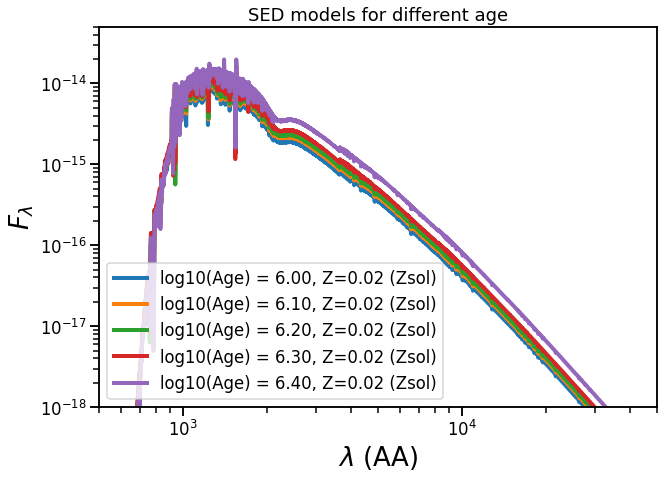

In [345]:
i = 0
sns.set_context("poster")
plt.figure(figsize=(10,7))

sed_set = []
age_set = []
for age in Age_arr:
    if i == 5:
        break
    i+= 1
    logAge2 = np.round(np.log10(age), 2)
    Z2 = 1.e-2
    theta2 = np.array([logAge2, Z2])
    spec = gen_SED(theta2)
    sns.set_context("talk")
    plt.plot(spec.wave, spec.flux, lw=4,label='log10(Age) = %.2f, Z=0.02 (Zsol)'%logAge2)
    age_set.append(logAge2)
    sed_set.append(spec)
    
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylim((1.e-18, 5.e-14))
plt.xlim((5.e2, 5.e4))
plt.xlabel("$\lambda$ (AA)",fontsize=26)
plt.ylabel(r"$F_{\lambda}$",fontsize=26)
plt.title("SED models for different age")

In [ ]:
flux_diffs = np.array([x.flux for x in sed_set[1:]]) - np.array([x.flux for x in sed_set[:-1]])

#plt.figure(figsize=(10,7))
plt.plot(wave_orig, abschange, ls='--')
plt.xscale("log")
plt.yscale("log")
plt.ylim((1.e-18, 1.e-14))
plt.xlim((5.e2, 5.e4))
plt.plot(spec.wave, flux_diffs[0], alpha=0.5)
#plt.plot(spec.wave, flux_diffs[1], alpha=0.5)
#plt.plot(spec.wave, flux_diffs[2], alpha=0.5)
#plt.plot(spec.wave, flux_diffs[3], alpha=0.5)
plt.plot(spec.wave, 0.5*np.nanmedian([flux_diffs[0], flux_diffs[1], flux_diffs[2], flux_diffs[3]], axis=0), alpha=0.5, ls=':')
plt.title("absolute change from GP perturbation");
plt.xlabel("$\lambda$ (AA)",fontsize=26);
plt.ylabel(r"$\delta F_{\lambda}$",fontsize=26);

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


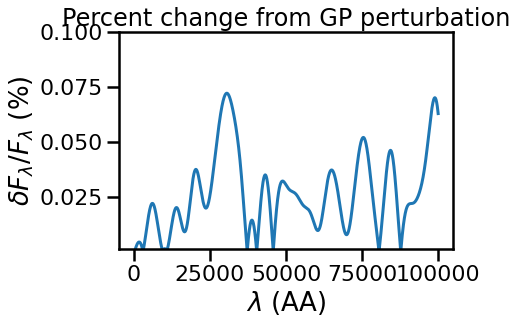

In [294]:
pchange = np.abs(flux_orig - flux_mod)/flux_orig
abschange = np.abs(flux_orig - flux_mod)
pchange = np.nan_to_num(pchange, nan=1.e-20)
abschange = np.nan_to_num(abschange, nan=1.e-20)
plt.plot(wave_orig, pchange)
#plt.xscale("log")
#plt.yscale("log")
#plt.ylim((1.e-22, 5.e-14))
#plt.xlim((5.e2, 5.e4))
plt.ylim(0.001, 0.1)
plt.xlabel("$\lambda$ (AA)",fontsize=26)
plt.ylabel(r"$\delta F_{\lambda}/F_{\lambda}$ (%)",fontsize=26)
plt.title("Percent change from GP perturbation");
plt.show()